In [1]:
# Jan 6, 2020, ETHZ
# Deep learning course - Project

# Import FROG traces and labels from matlab

import glob
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import os

from tqdm import tqdm# for progress bar

# Plot data from a single file

In [2]:
print(os.getcwd())

C:\Users\FoS\Dropbox\Data science - ML - AI\DeepL_Attosecond pulse reconstruction\Data2Python


(4096,)
(4096,)


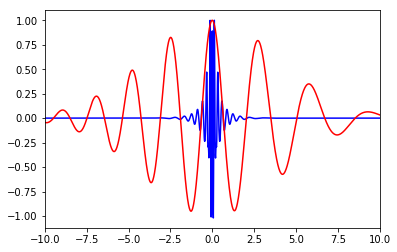

In [3]:
# plot time domain

#folder = 'XUVcenter_XUVFWHM_XUVp2/' # Mac

folder = 'c:\\Users\\FoS\\Desktop\\deep-reconstruction-of-attosecond-pulses\\sample_traces\\'# Windows

file_t = pd.read_csv(folder+'fields_1.csv', header=None).values

time_axis = file_t[0,:]
XUV_t = file_t[1,:]
IR_t = file_t[2,:]
print(time_axis.shape)
print(XUV_t.shape)

plt.plot(time_axis, XUV_t/np.max(XUV_t), 'b');
plt.plot(time_axis, IR_t/np.max(IR_t), 'r');
plt.xlim([-10,10]);
plt.show();

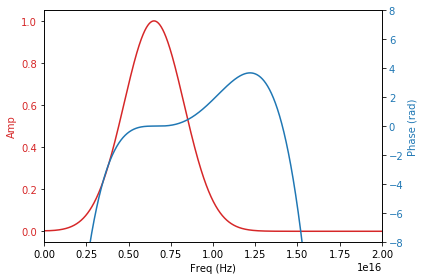

In [4]:
# plot frequency domain
file_f = pd.read_csv(folder+'/spectrum_1.csv', header=None).values
freq_axis = file_f[0,:]
XUV_amp = file_f[1,:]
XUV_phase = file_f[2,:]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Amp', color=color)
ax1.plot(freq_axis, XUV_amp/np.max(XUV_amp), color=color)
plt.xlim([0,2e16])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Phase (rad)', color=color)  # we already handled the x-label with ax1
ax2.plot(freq_axis, XUV_phase, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim((-8, 8))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Extract data from multiple files

In [5]:
#f_paths = [folder]

#f_paths = ['c:\\Users\\FoS\\Desktop\\deep-reconstruction-of-attosecond-pulses\\sample_traces\\'] # Windows
#f_paths = ['c:\\Users\\FoS\\Desktop\\deep-reconstruction-of-attosecond-pulses\\2020_03_30_XUV_all_IR_tau_I_1\\',
#           'c:\\Users\\FoS\\Desktop\\deep-reconstruction-of-attosecond-pulses\\2020_03_30_XUV_all_IR_tau_I_3\\'] # Windows
f_paths = ['c:\\Users\\FoS\\Desktop\\deep-reconstruction-of-attosecond-pulses\\2020_03_30_XUV_all_IR_tau_I_3\\'] # Windows


f_trace_name = 'trace_*.csv'

files = []

# List traces avaliable in the folder
for f_path in f_paths:
    print('Reading file:', f_path, '...')
    new_files = glob.glob(f_path+f_trace_name)
    print('Number of traces found:', len(new_files))
    files.extend(new_files)

print('Total number of traces:', len(files))

X = [] # Features
Y_values = [] # Labels (values)
XUV_field_f = np.zeros((len(files), len(freq_axis)*2)) #1D vector containing intensity and phase of XUV field in freq. domain
XUV_field_t = np.zeros((len(files), len(time_axis))) #1D vector containing XUV field (real) in time domain
IR_field_t = np.zeros((len(files), len(time_axis))) #1D vector containing IR field (real) in time domain

# Prepare feature vector
print('Reading data ...', flush=True)
tic = time.time()
count = 0
for f in tqdm(files) :
    with open(f, 'r') as fd:
        X.append(pd.read_csv(fd, header=None).values)
    with open(f.replace('trace_', 'labels_'), 'r') as fd:
        Y_values.append( np.ravel(pd.read_csv(fd, header=None).values) )
    with open(f.replace('trace_', 'fields_'), 'r') as fd:
        temp = (pd.read_csv(fd, header=None).values)
        XUV_field_t[count,:] = temp[1,:]
        IR_field_t[count,:] = temp[2,:]
    with open(f.replace('trace_', 'spectrum_'), 'r') as fd:
        temp = (pd.read_csv(fd, header=None).values)
        XUV_field_f[count,0:len(freq_axis)] = temp[1,:]
        XUV_field_f[count,len(freq_axis)::] = temp[2,:]
    count += 1
    
# Read tau (from tauaxis.csv) and W axes (from Waxis.csv)
with open(f_path+'tauaxis.csv','r') as fd:
    tau_axis = np.ravel(pd.read_csv(fd, header=None).values)

with open(f_path+'Waxis.csv','r') as fd:
    W_axis   = np.ravel(pd.read_csv(fd, header=None).values)
    
toc = time.time()
print('Done!', flush=True)
print('Time:', toc-tic, 's')

# Convert list to np array
X = np.array(X)
Y_values = np.array(Y_values)

# Header for the Y_values
Y_values_header = {i:j for i,j in 
                   enumerate('IR_tau,IR_Inten,IR_cr,XUV_FWHM,XUV_center,XUV_p2,XUV_p3,XUV_p4,XUV_p5,tau_FWHM,T_IR'.split(','))}

print('Feature vector shape:  ', X.shape)
print('Y_values vector shape: ', Y_values.shape)
print('tau axis shape:        ', tau_axis.shape)
print('W axis shape:          ', W_axis.shape)
print('Y_values_header:       ', Y_values_header)

print('XUV_field_f shape:       ', XUV_field_f.shape)
print('freq_axis shape:         ', freq_axis.shape)
print('XUV_field_t shape:       ', XUV_field_t.shape)
print('IR_field_t shape:        ', IR_field_t.shape)
print('time_axis shape:         ', time_axis.shape)

print('Pickling data ...')

#f_pickle_out = f_path.split('/') [-2] + '.pickle' # Mac
f_pickle_out = f_path.split('\\')[-2] + '.pickle' # Windows
with open(f_pickle_out, 'wb') as fd:
    pickle.dump([tau_axis, W_axis, X,
                 Y_values, Y_values_header,
                 freq_axis, XUV_field_f,
                 time_axis, XUV_field_t, IR_field_t], fd)

print('Data saved to:         ', f_pickle_out)


Reading file: c:\Users\FoS\Desktop\deep-reconstruction-of-attosecond-pulses\2020_03_30_XUV_all_IR_tau_I_3\ ...
Number of traces found: 21862
Total number of traces: 21862
Reading data ...


100%|██████████████████████████████████████████████████████████████████████████| 21862/21862 [2:16:37<00:00,  2.67it/s]

Done!


Time: 8197.885999679565 s
Feature vector shape:   (21862, 64, 80)
Y_values vector shape:  (21862, 11)
tau axis shape:         (80,)
W axis shape:           (64,)
Y_values_header:        {0: 'IR_tau', 1: 'IR_Inten', 2: 'IR_cr', 3: 'XUV_FWHM', 4: 'XUV_center', 5: 'XUV_p2', 6: 'XUV_p3', 7: 'XUV_p4', 8: 'XUV_p5', 9: 'tau_FWHM', 10: 'T_IR'}
XUV_field_f shape:        (21862, 6400)
freq_axis shape:          (3200,)
XUV_field_t shape:        (21862, 4096)
IR_field_t shape:         (21862, 4096)
time_axis shape:          (4096,)
Pickling data ...
Data saved to:          2020_03_30_XUV_all_IR_tau_I_3.pickle


# Check if everything is in the pickle file

In [ ]:
#f_pickle_name = 'XUVcenter_XUVFWHM_XUVp2_test.pickle'
f_pickle_name  = 'sample_traces.pickle'

with open(f_pickle_name, 'rb') as fd:
    [tau_axis, W_axis, X,
     Y_values, Y_values_header,
     freq_axis, XUV_field_f,
     time_axis, XUV_field_t, IR_field_t] = pickle.load(fd)
print('Data read from pickle file', f_pickle_name)

print('Feature vector shape:  ', X.shape)
print('Y_values vector shape: ', Y_values.shape)
print('tau axis shape:        ', tau_axis.shape)
print('W axis shape:          ', W_axis.shape)
print('Y_values_header:       ', Y_values_header)

print('XUV_field_f shape:       ', XUV_field_f.shape)
print('freq_axis shape:         ', freq_axis.shape)
print('XUV_field_t shape:       ', XUV_field_t.shape)
print('IR_field_t shape:        ', IR_field_t.shape)
print('time_axis shape:         ', time_axis.shape)

In [ ]:
#plot to test
trace_num = 4
plt.plot(time_axis, XUV_field_t[trace_num, :]/np.max(XUV_field_t[trace_num, :]), 'b')
plt.plot(time_axis, IR_field_t[trace_num, :]/np.max(IR_field_t[trace_num, :]), 'r')
plt.xlim([-10,10])
plt.xlabel('Time (fs)', fontsize = 16)
plt.ylabel('Norm Ampl. (arb. u.)', fontsize = 16)
plt.show()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Freq (Hz)', fontsize = 16)
ax1.set_ylabel('Norm. Ampl.', color=color, fontsize = 16)
ax1.plot(freq_axis, XUV_field_f[trace_num, 0:len(freq_axis)]/np.max(XUV_field_f[trace_num, 0:len(freq_axis)]), color=color)
plt.xlim([0,2e16])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Phase (rad)', color=color, fontsize = 16)  # we already handled the x-label with ax1
ax2.plot(freq_axis, XUV_field_f[trace_num, len(freq_axis)::], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim((-8, 8))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()